In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as graph
import seaborn as sns
import cartopy
import cartopy.crs as ccrs

from tqdm import tqdm
import swifter

from osgeo import ogr, osr
from joblib import Parallel, delayed

tqdm.pandas()
import xarray as xr
from global_land_mask import globe
import geopandas as gpd
import geoplot

from datetime import date
today_date = date.today().strftime("%b_%d").lower()
import os

from convertbng.util import convert_bng, convert_lonlat
import utm

import shapefile as shp
from shapely.geometry import Point, Polygon, MultiPolygon

In [2]:
us_locations = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/US_hydrolakes_lake_caracteristics_oct_04.csv')
us_locations.sort_values(by='Hylak_id', inplace=True)
print(len(us_locations))
display(us_locations.head())

91695


,latitude,longitude,hydro_id,ocean,hydro_dist,Hylak_id,Lake_name,Country,Continent,Poly_src,...,Vol_res,Vol_src,Depth_avg,Dis_avg,Res_time,Elevation,Slope_100,Wshd_area,Pour_long,Pour_lat
70824,46.6584,-90.8385,5.0,NO,0.0,5.0,Superior,United States of America,North America,SWBD,...,0.0,1.0,146.7,2869.953,48410.3,179.0,-1.0,209219.5,-84.460547,46.468593
12156,48.7691,-86.6304,5.0,NO,0.0,5.0,Superior,United States of America,North America,SWBD,...,0.0,1.0,146.7,2869.953,48410.3,179.0,-1.0,209219.5,-84.460547,46.468593
12157,46.5160,-84.7083,5.0,NO,0.0,5.0,Superior,United States of America,North America,SWBD,...,0.0,1.0,146.7,2869.953,48410.3,179.0,-1.0,209219.5,-84.460547,46.468593
12158,48.2475,-89.1691,5.0,NO,0.0,5.0,Superior,United States of America,North America,SWBD,...,0.0,1.0,146.7,2869.953,48410.3,179.0,-1.0,209219.5,-84.460547,46.468593
12159,47.6950,-90.5419,5.0,NO,0.0,5.0,Superior,United States of America,North America,SWBD,...,0.0,1.0,146.7,2869.953,48410.3,179.0,-1.0,209219.5,-84.460547,46.468593


In [3]:
len(us_locations['Hylak_id'].unique())

14279

In [7]:
canada_lakes = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/hydrolakes_ahi_bsm_sapna_lake_caracteristics_aug_26.csv')
print(len(canada_lakes))
display(canada_lakes)

24209


,Hylak_id,wby_name,Country,Continent,lake_area_km2,mean_depth_m,lake_elevation_(m),longitude,latitude,dataset,surface_area_ha,max_depth_m,made_up_code
0,NaN,Bowlby P.,NaN,NaN,0.001,1.5,201.0,-80.261111,42.793056,ahi_bsm,NaN,NaN,NaN
1,NaN,"B, L.",NaN,NaN,0.001,NaN,326.0,-80.200000,43.450000,ahi_bsm,NaN,NaN,NaN
2,NaN,"H-A, L.",NaN,NaN,0.001,NaN,332.0,-80.166667,43.500000,ahi_bsm,NaN,NaN,NaN
3,NaN,Eby Ph.,NaN,NaN,0.002,1.2,320.0,-80.163333,48.032500,ahi_bsm,NaN,NaN,NaN
4,NaN,Vances L.,NaN,NaN,0.002,1.6,265.0,-81.375000,44.233889,ahi_bsm,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24204,NaN,6206,NaN,NaN,NaN,NaN,NaN,-101.877200,54.780280,NaN,NaN,NaN,C_MAN_S_000533
24205,NaN,7170,NaN,NaN,NaN,NaN,NaN,-99.996940,56.483330,NaN,NaN,NaN,C_MAN_S_000560
24206,NaN,7298,NaN,NaN,NaN,NaN,NaN,-101.172700,56.087500,NaN,NaN,NaN,C_MAN_S_000569
24207,NaN,8376,NaN,NaN,NaN,NaN,NaN,-101.650000,58.483330,NaN,NaN,NaN,C_MAN_S_000594


In [5]:
canada_lakes.loc[(canada_lakes['dataset'] != 'hydrolakes') & 
                 (~canada_lakes['made_up_code'].isna())].sort_values(by='lake_area_km2', ascending=False)

,Hylak_id,wby_name,Country,Continent,lake_area_km2,mean_depth_m,lake_elevation_(m),longitude,latitude,dataset,surface_area_ha,max_depth_m,made_up_code
23768,NaN,NaN,NaN,NaN,6931.23100,25.5,NaN,-119.931586,51.153660,NaN,693123.100,67.0,C_BC_S_003421
23750,NaN,LAC MISTASSINI,NaN,NaN,2113.43000,NaN,NaN,-73.363889,51.111111,NaN,211343.000,NaN,C_QC_S_000158
23744,NaN,NaN,NaN,NaN,1609.69400,9.3,NaN,-123.204515,50.233043,NaN,160969.400,27.1,C_BC_S_003420
23731,NaN,NaN,NaN,NaN,1101.17475,85.6,NaN,-120.376433,59.710451,NaN,110117.475,283.5,C_BC_S_003419
23728,NaN,NaN,NaN,NaN,1036.00000,99.7,NaN,-119.402408,52.425265,NaN,103600.000,236.2,C_BC_S_003418
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24204,NaN,6206,NaN,NaN,NaN,NaN,NaN,-101.877200,54.780280,NaN,NaN,NaN,C_MAN_S_000533
24205,NaN,7170,NaN,NaN,NaN,NaN,NaN,-99.996940,56.483330,NaN,NaN,NaN,C_MAN_S_000560
24206,NaN,7298,NaN,NaN,NaN,NaN,NaN,-101.172700,56.087500,NaN,NaN,NaN,C_MAN_S_000569
24207,NaN,8376,NaN,NaN,NaN,NaN,NaN,-101.650000,58.483330,NaN,NaN,NaN,C_MAN_S_000594


In [6]:
len(canada_lakes.loc[canada_lakes['dataset'] != 'hydrolakes']['made_up_code'].unique())

3256

In [9]:
canada_lakes['dataset'].value_counts(dropna=False)

hydrolakes    20528
NaN            3255
ahi_bsm         426
Name: dataset, dtype: int64

In [13]:
len(canada_lakes.loc[(canada_lakes['dataset'] == 'hydrolakes')]['Hylak_id'].unique())

20528

# Test

In [41]:
locations = pd.read_csv('/mnt/c/Users/imrit/Desktop/GEnfish_locations_ids_jan_12_2022.csv')
locations = locations.loc[locations['hydro_waterbody'] == 'lake']
locations = locations[['latitude', 'longitude', 'hydro_match', 'made_up_code']]

locations['latitude'] = locations['latitude'].round(decimals=6)
locations['longitude'] = locations['longitude'].round(decimals=6)
    
locations

/home/arshad/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (6,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,latitude,longitude,hydro_match,made_up_code
0,45.095566,-74.434094,"[0.0, 754]",CA_HYD_754.0
1,43.522660,-94.377540,"[956.1229859299261, 110921]",CA_HYD_110921.0
2,45.250660,-96.313880,"[569.6211321751174, 109208]",CA_HYD_109208.0
3,47.794910,-92.063760,"[345.7506452063405, 104923]",CA_HYD_104923.0
4,36.224870,-94.542000,"[50.0622149021188, 1059841]",CA_HYD_1059841.0
...,...,...,...,...
167780,41.571400,-82.777000,"[0.0, 9]",CA_HYD_9.0
167781,44.340279,-78.451668,"[3.943860609349279, 761]",CA_HYD_761.0
167782,47.963335,-77.689692,"[0.0, 8426]",CA_HYD_8426.0
167783,41.951100,-82.984700,"[0.0, 9]",CA_HYD_9.0


In [42]:
sapna_bc = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/Processed/testing_sapna_BC_compiled_no_year_dont_use.csv')
sapna_bc = sapna_bc.iloc[:10]
for col in ['latitude', 'longitude']:
    sapna_bc[col] = sapna_bc[col].round(decimals=6)
sapna_bc

,surface_area,depth_maximum,depth_mean,volume,ph_surface,tds_surface,secchi_disc_depth,alosa_sapidissima,salvelinus_confluentus,salvelinus_alpinus,...,cottus_rhotheus,percopsis_omiscomaycus,sander_vitreus,lampetra_richardsoni,acipenser_transmontanus,catostomus_commersonii,perca_flavescens,year,latitude,longitude
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.345224,-90.122200
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,-120.000000
2,0.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999.0,51.536928,-120.899157
3,0.27,5.5,2.3,61000.0,8.4,142.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999.0,49.208722,-121.665403
4,0.36,6.2,2.6,9150.0,8.0,136.0,5.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999.0,58.415997,-121.353056
5,0.39,2.5,0.8,3300.0,7.9,1740.0,1.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999.0,49.307259,-122.090631
6,0.59,5.0,2.6,155700.0,7.1,112.0,1.9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999.0,49.495431,-122.737234
7,0.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999.0,52.272584,-120.427018
8,0.60,3.0,1.4,8280.0,6.3,30.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999.0,54.296847,-122.883947
9,0.60,4.3,NaN,NaN,NaN,102.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999.0,53.446500,-121.886588


In [43]:
merged = pd.merge(sapna_bc, locations, on = ['latitude', 'longitude'], how='inner')
merged

,surface_area,depth_maximum,depth_mean,volume,ph_surface,tds_surface,secchi_disc_depth,alosa_sapidissima,salvelinus_confluentus,salvelinus_alpinus,...,sander_vitreus,lampetra_richardsoni,acipenser_transmontanus,catostomus_commersonii,perca_flavescens,year,latitude,longitude,hydro_match,made_up_code
0,0.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-999.0,51.536928,-120.899157,"[0.0, 924836]",CA_HYD_924836.0
1,0.27,5.5,2.3,61000.0,8.4,142.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-999.0,49.208722,-121.665403,"[nan, nan]",C_BC_S_000001
2,0.36,6.2,2.6,9150.0,8.0,136.0,5.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-999.0,58.415997,-121.353056,"[nan, nan]",C_BC_S_000002
3,0.39,2.5,0.8,3300.0,7.9,1740.0,1.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-999.0,49.307259,-122.090631,"[115.68520086002012, 977393]",CA_HYD_977393.0
4,0.39,2.5,0.8,3300.0,7.9,1740.0,1.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-999.0,49.307259,-122.090631,"[115.68524701644492, 977393]",CA_HYD_977393.0
5,0.59,5.0,2.6,155700.0,7.1,112.0,1.9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-999.0,49.495431,-122.737234,"[nan, nan]",C_BC_S_000004
6,0.60,3.0,1.4,8280.0,6.3,30.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-999.0,54.296847,-122.883947,"[nan, nan]",C_BC_S_000006
7,0.60,4.3,NaN,NaN,NaN,102.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-999.0,53.446500,-121.886588,"[nan, nan]",C_BC_S_000007


In [33]:
locations.loc[locations['made_up_code'] == 'C_BC_S_000000']

,latitude,longitude,hydro_match,hydro_dist,hydro_id,ocean,match2river,river_hydro_dist,river_hydro_id,hydro_waterbody,lake_name,made_up_code


# Merge Canada and US locations
Same lakes in canada and US

In [112]:
coords_bc = pd.read_csv('/mnt/c/Users/imrit/Desktop/bc_new_hydrolakes_match.csv')
coords_bc['hydro_waterbody'] = np.where(~coords_bc['hydro_dist'].isna(), 'lake', coords_bc['hydro_waterbody'])
coords_bc = coords_bc.loc[coords_bc['hydro_waterbody'] == 'lake']
coords_bc.rename(columns = {'hydro_id': 'Hylak_id'}, inplace=True)

coords_bc['made_up_code'] = 'CA_HYD_' + coords_bc['Hylak_id'].astype(str)
print(len(coords_bc))
print(len(coords_bc['Hylak_id'].unique()))
display(coords_bc)

8245
2709


,latitude,longitude,hydro_match,hydro_dist,Hylak_id,ocean,match2river,river_hydro_dist,river_hydro_id,hydro_waterbody,made_up_code
4,57.570000,-154.450000,"[85.37035627497691, 70665]",85.370356,70665.0,NO,"[nan, nan]",NaN,NaN,lake,CA_HYD_70665.0
7,58.250000,-157.380000,"[113.77951973175233, 709899]",113.779520,709899.0,NO,"[nan, nan]",NaN,NaN,lake,CA_HYD_709899.0
12,51.232829,-127.339217,"[5.2393671332398775, 96083]",5.239367,96083.0,NO,"[nan, nan]",NaN,NaN,lake,CA_HYD_96083.0
14,54.380995,-126.127000,"[97.40499420366376, 83376]",97.404994,83376.0,NO,"[nan, nan]",NaN,NaN,lake,CA_HYD_83376.0
19,54.445701,-125.459268,"[77.09805806289931, 517]",77.098058,517.0,NO,NaN,NaN,NaN,lake,CA_HYD_517.0
...,...,...,...,...,...,...,...,...,...,...,...
26252,62.709350,-143.591100,"[0.0, 51241]",0.000000,51241.0,NO,"[nan, nan]",NaN,NaN,lake,CA_HYD_51241.0
26253,60.405580,-144.294800,"[0.0, 59620]",0.000000,59620.0,NO,"[nan, nan]",NaN,NaN,lake,CA_HYD_59620.0
26254,61.049480,-147.499600,"[0.0, 606397]",0.000000,606397.0,NO,"[nan, nan]",NaN,NaN,lake,CA_HYD_606397.0
26272,60.696820,-135.041900,"[136.06120037191846, 58557]",136.061200,58557.0,NO,"[nan, nan]",NaN,NaN,lake,CA_HYD_58557.0


In [113]:
canada_locations = pd.read_csv('/mnt/c/Users/imrit/Desktop/GEnfish_locations_ids_jan_12_2022.csv')
canada_locations.rename(columns = {'hydro_id': 'Hylak_id'}, inplace=True)

us_locations = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project//US_hydrolakes_lake_caracteristics_oct_04.csv')
us_locations['made_up_code'] = 'US_HYD_' + us_locations['Hylak_id'].astype(str)
us_locations['hydro_waterbody'] = 'lake'

display(canada_locations.head())
display(us_locations.head())

/home/arshad/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (6,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,latitude,longitude,hydro_match,hydro_dist,Hylak_id,ocean,match2river,river_hydro_dist,river_hydro_id,hydro_waterbody,lake_name,made_up_code
0,45.095566,-74.434094,"[0.0, 754]",0.000000,754.0,NO,NaN,NaN,NaN,lake,NaN,CA_HYD_754.0
1,43.522660,-94.377540,"[956.1229859299261, 110921]",956.122986,110921.0,NO,NaN,NaN,NaN,lake,NaN,CA_HYD_110921.0
2,45.250660,-96.313880,"[569.6211321751174, 109208]",569.621132,109208.0,NO,NaN,NaN,NaN,lake,NaN,CA_HYD_109208.0
3,47.794910,-92.063760,"[345.7506452063405, 104923]",345.750645,104923.0,NO,NaN,NaN,NaN,lake,NaN,CA_HYD_104923.0
4,36.224870,-94.542000,"[50.0622149021188, 1059841]",50.062215,1059841.0,NO,NaN,NaN,NaN,lake,NaN,CA_HYD_1059841.0


,latitude,longitude,hydro_id,ocean,hydro_dist,Hylak_id,Lake_name,Country,Continent,Poly_src,...,Depth_avg,Dis_avg,Res_time,Elevation,Slope_100,Wshd_area,Pour_long,Pour_lat,made_up_code,hydro_waterbody
0,45.01527,-71.632880,109510.0,NO,0.000000,109510.0,NaN,United States of America,North America,SWBD,...,9.5,1.004,238.9,390.0,5.36,45.1,-71.615685,45.011404,US_HYD_109510.0,lake
1,47.21893,-69.574935,106047.0,NO,0.000000,106047.0,NaN,United States of America,North America,SWBD,...,12.0,3.545,275.5,322.0,4.70,181.1,-69.528058,47.162226,US_HYD_106047.0,lake
2,49.07637,-119.518180,8219.0,NO,73.063122,8219.0,Osoyoos Lake,United States of America,North America,SWBD,...,13.8,34.776,103.4,277.0,3.21,8177.1,-119.431149,48.952613,US_HYD_8219.0,lake
3,41.56480,-82.790000,9.0,NO,0.000000,9.0,Erie,United States of America,North America,SWBD,...,19.4,9796.883,589.5,172.0,-1.00,679903.4,-78.908084,42.904334,US_HYD_9.0,lake
4,41.56080,-82.783500,9.0,NO,0.000000,9.0,Erie,United States of America,North America,SWBD,...,19.4,9796.883,589.5,172.0,-1.00,679903.4,-78.908084,42.904334,US_HYD_9.0,lake


In [114]:
canada_locations_bc = pd.concat([canada_locations, coords_bc])
print(len(canada_locations_bc))
canada_locations_bc.drop_duplicates(inplace=True)
print(len(canada_locations_bc))
canada_locations_bc.sort_values(by='hydro_waterbody', na_position='last', inplace=True)
canada_locations_bc.drop_duplicates(subset=['latitude', 'longitude'], keep='first', inplace=True)
print(len(canada_locations_bc))
canada_locations_bc

965677
963818
957432


,latitude,longitude,hydro_match,hydro_dist,Hylak_id,ocean,match2river,river_hydro_dist,river_hydro_id,hydro_waterbody,lake_name,made_up_code
0,45.095566,-74.434094,"[0.0, 754]",0.0,754.0,NO,NaN,NaN,NaN,lake,NaN,CA_HYD_754.0
116110,44.488300,-86.332200,"[0.0, 6]",0.0,6.0,NO,NaN,NaN,NaN,lake,NaN,CA_HYD_6.0
116111,45.669600,-83.887600,"[0.0, 8]",0.0,8.0,NO,NaN,NaN,NaN,lake,NaN,CA_HYD_8.0
116112,45.200000,-85.656700,"[0.0, 6]",0.0,6.0,NO,NaN,NaN,NaN,lake,NaN,CA_HYD_6.0
116113,45.510000,-81.146200,"[0.0, 8]",0.0,8.0,NO,NaN,NaN,NaN,lake,NaN,CA_HYD_8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
957427,61.693130,-150.312200,"[nan, nan]",NaN,NaN,NO,"[nan, nan]",NaN,NaN,NaN,NaN,NaN
957428,60.056000,-151.663100,"[nan, nan]",NaN,NaN,NO,"[nan, nan]",NaN,NaN,NaN,NaN,NaN
957429,61.534090,-149.267000,"[nan, nan]",NaN,NaN,NO,"[nan, nan]",NaN,NaN,NaN,NaN,NaN
957430,59.457950,-139.571400,"[nan, nan]",NaN,NaN,NO,"[nan, nan]",NaN,NaN,NaN,NaN,NaN


In [115]:
canada_locations_bc.to_csv('/mnt/c/Users/imrit/Desktop/GEnfish_locations_ids_jan_14_2022.csv', index=False)

In [106]:
canada_us_locations = pd.concat([canada_locations_bc, us_locations])
canada_us_locations = canada_us_locations[['latitude', 'longitude', 'hydro_match', 'hydro_dist', 'hydro_waterbody', 'Hylak_id', 
                                           'Country', 'Continent', 'made_up_code']]
canada_us_locations = canada_us_locations.loc[canada_us_locations['hydro_waterbody'] == 'lake']
canada_us_locations['country_code'] = canada_us_locations['made_up_code'].str.split('_').str.get(0)
canada_us_locations

,latitude,longitude,hydro_match,hydro_dist,hydro_waterbody,Hylak_id,Country,Continent,made_up_code,country_code
0,45.095566,-74.434094,"[0.0, 754]",0.000000,lake,754.0,NaN,NaN,CA_HYD_754.0,CA
117348,43.653100,-76.151900,"[470.40464970534646, 7]",470.404650,lake,7.0,NaN,NaN,CA_HYD_7.0,CA
117349,46.910000,-90.550000,"[80.80810024786143, 5]",80.808100,lake,5.0,NaN,NaN,CA_HYD_5.0,CA
117350,39.759170,-79.391390,"[0.0, 112213]",0.000000,lake,112213.0,NaN,NaN,CA_HYD_112213.0,CA
117351,42.133270,-80.142370,"[1.7791015131229275, 9]",1.779102,lake,9.0,NaN,NaN,CA_HYD_9.0,CA
...,...,...,...,...,...,...,...,...,...,...
91690,43.771000,-79.142400,NaN,211.608253,lake,7.0,United States of America,North America,US_HYD_7.0,US
91691,43.826000,-79.088600,NaN,456.711406,lake,7.0,United States of America,North America,US_HYD_7.0,US
91692,43.822300,-79.072600,NaN,432.277693,lake,7.0,United States of America,North America,US_HYD_7.0,US
91693,43.622100,-79.482700,NaN,120.735138,lake,7.0,United States of America,North America,US_HYD_7.0,US


In [107]:
canada_us_locations['hyd_code'] = (canada_us_locations['made_up_code'].str.split('_').str.get(1) + '_' + 
                                   canada_us_locations['made_up_code'].str.split('_').str.get(2))
canada_us_locations

,latitude,longitude,hydro_match,hydro_dist,hydro_waterbody,Hylak_id,Country,Continent,made_up_code,country_code,hyd_code
0,45.095566,-74.434094,"[0.0, 754]",0.000000,lake,754.0,NaN,NaN,CA_HYD_754.0,CA,HYD_754.0
117348,43.653100,-76.151900,"[470.40464970534646, 7]",470.404650,lake,7.0,NaN,NaN,CA_HYD_7.0,CA,HYD_7.0
117349,46.910000,-90.550000,"[80.80810024786143, 5]",80.808100,lake,5.0,NaN,NaN,CA_HYD_5.0,CA,HYD_5.0
117350,39.759170,-79.391390,"[0.0, 112213]",0.000000,lake,112213.0,NaN,NaN,CA_HYD_112213.0,CA,HYD_112213.0
117351,42.133270,-80.142370,"[1.7791015131229275, 9]",1.779102,lake,9.0,NaN,NaN,CA_HYD_9.0,CA,HYD_9.0
...,...,...,...,...,...,...,...,...,...,...,...
91690,43.771000,-79.142400,NaN,211.608253,lake,7.0,United States of America,North America,US_HYD_7.0,US,HYD_7.0
91691,43.826000,-79.088600,NaN,456.711406,lake,7.0,United States of America,North America,US_HYD_7.0,US,HYD_7.0
91692,43.822300,-79.072600,NaN,432.277693,lake,7.0,United States of America,North America,US_HYD_7.0,US,HYD_7.0
91693,43.622100,-79.482700,NaN,120.735138,lake,7.0,United States of America,North America,US_HYD_7.0,US,HYD_7.0


In [108]:
canus_codes = canada_us_locations[['Hylak_id', 'country_code', 'made_up_code', 'hyd_code']].dropna(subset=['Hylak_id'])
canus_codes.drop_duplicates(inplace=True)
canus_codes.sort_values(by='Hylak_id', inplace=True)

canus_codes = canus_codes.loc[canus_codes.duplicated(subset='Hylak_id', keep=False)]
canus_codes['made_up_code_merged'] = 'CANUS_HYD_' + canus_codes['Hylak_id'].astype(str)
canus_codes = canus_codes[['made_up_code', 'made_up_code_merged']]

print(len(canus_codes['made_up_code_merged'].unique()))
canus_codes

14353


,made_up_code,made_up_code_merged
19,US_HYD_5.0,CANUS_HYD_5.0
117349,CA_HYD_5.0,CANUS_HYD_5.0
61,US_HYD_6.0,CANUS_HYD_6.0
117352,CA_HYD_6.0,CANUS_HYD_6.0
15,US_HYD_7.0,CANUS_HYD_7.0
...,...,...
5942,CA_HYD_1069943.0,CANUS_HYD_1069943.0
75607,CA_HYD_1069945.0,CANUS_HYD_1069945.0
9530,US_HYD_1069945.0,CANUS_HYD_1069945.0
7704,US_HYD_1069952.0,CANUS_HYD_1069952.0


In [109]:
canada_us_locations = canada_us_locations.merge(df_lake_codes, how='left')
canada_us_locations

,latitude,longitude,hydro_match,hydro_dist,hydro_waterbody,Hylak_id,Country,Continent,made_up_code,country_code,hyd_code,made_up_code_merged
0,45.095566,-74.434094,"[0.0, 754]",0.000000,lake,754.0,NaN,NaN,CA_HYD_754.0,CA,HYD_754.0,NaN
1,43.653100,-76.151900,"[470.40464970534646, 7]",470.404650,lake,7.0,NaN,NaN,CA_HYD_7.0,CA,HYD_7.0,CANUS_HYD_7.0
2,46.910000,-90.550000,"[80.80810024786143, 5]",80.808100,lake,5.0,NaN,NaN,CA_HYD_5.0,CA,HYD_5.0,CANUS_HYD_5.0
3,39.759170,-79.391390,"[0.0, 112213]",0.000000,lake,112213.0,NaN,NaN,CA_HYD_112213.0,CA,HYD_112213.0,CANUS_HYD_112213.0
4,42.133270,-80.142370,"[1.7791015131229275, 9]",1.779102,lake,9.0,NaN,NaN,CA_HYD_9.0,CA,HYD_9.0,CANUS_HYD_9.0
...,...,...,...,...,...,...,...,...,...,...,...,...
265839,43.771000,-79.142400,NaN,211.608253,lake,7.0,United States of America,North America,US_HYD_7.0,US,HYD_7.0,CANUS_HYD_7.0
265840,43.826000,-79.088600,NaN,456.711406,lake,7.0,United States of America,North America,US_HYD_7.0,US,HYD_7.0,CANUS_HYD_7.0
265841,43.822300,-79.072600,NaN,432.277693,lake,7.0,United States of America,North America,US_HYD_7.0,US,HYD_7.0,CANUS_HYD_7.0
265842,43.622100,-79.482700,NaN,120.735138,lake,7.0,United States of America,North America,US_HYD_7.0,US,HYD_7.0,CANUS_HYD_7.0


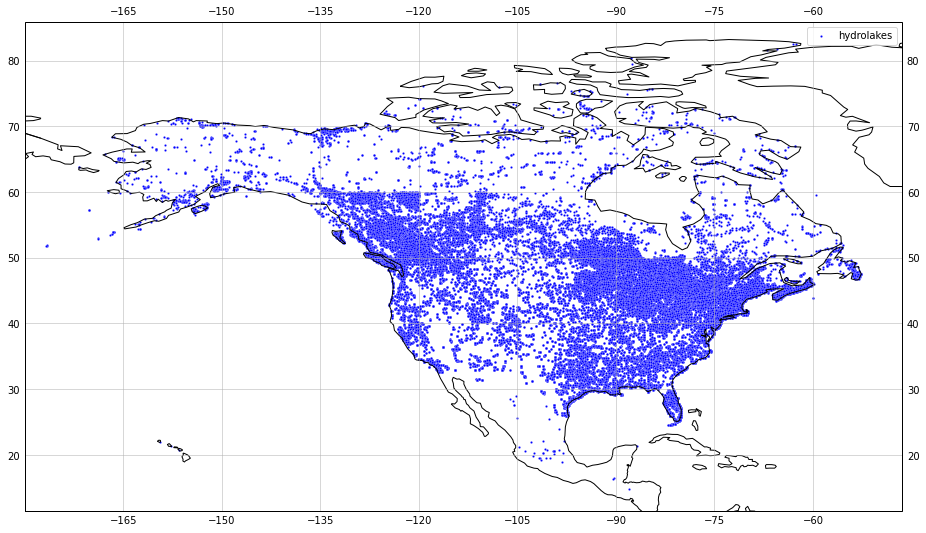

CPU times: user 6.22 s, sys: 266 ms, total: 6.48 s
Wall time: 6.01 s


In [110]:
%%time
graph.figure(figsize=(16, 9))
ax = graph.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, linewidth = 0.5)

sns.scatterplot(canada_us_locations['longitude'], canada_us_locations['latitude'],
                transform=ccrs.PlateCarree(), s=5, label = 'hydrolakes', color = 'blue')

graph.show()


In [3]:
fish_df = pd.read_csv('/mnt/c/Users/imrit/Desktop/GENFISH_canada_us_fish_occurence_jan_21_2022.csv')
fish_df.head()

,made_up_code_merged,year,ablennes_hians,abudefduf_saxatilis,acantharchus_pomotis,acanthocybium_solandri,acantholiparis_opercularis,acantholumpenus_mackayi,acanthostracion_polygonius,acanthuridae_spp,...,zaniolepis_latipinnis,zaprora_silenus,zaproridae_spp,zeidae_spp,zenion_hololepis,zenopsis_conchifer,zesticelus_profundorum,zoarces_americanus,zoarcidae_spp,zu_cristatus
0,CA_HYD_1038221.0,2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CA_HYD_1037525.0,2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CA_HYD_1038157.0,2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CA_HYD_1037792.0,2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CA_HYD_1038820.0,2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
[code for code in fish_df['made_up_code_merged'].unique() if 'CANUS' in code]

['CANUS_HYD_109510.0',
 'CANUS_HYD_106047.0',
 'CANUS_HYD_8219.0',
 'CANUS_HYD_9.0',
 'CANUS_HYD_7.0',
 'CANUS_HYD_5.0',
 'CANUS_HYD_1055133.0',
 'CANUS_HYD_1057180.0',
 'CANUS_HYD_6.0',
 'CANUS_HYD_1056920.0',
 'CANUS_HYD_9247.0',
 'CANUS_HYD_112070.0',
 'CANUS_HYD_8.0',
 'CANUS_HYD_1057944.0',
 'CANUS_HYD_758.0',
 'CANUS_HYD_1051544.0',
 'CANUS_HYD_1050585.0',
 'CANUS_HYD_102487.0',
 'CANUS_HYD_1054917.0',
 'CANUS_HYD_111234.0',
 'CANUS_HYD_809.0',
 'CANUS_HYD_1049120.0',
 'CANUS_HYD_9360.0',
 'CANUS_HYD_1056192.0',
 'CANUS_HYD_715.0',
 'CANUS_HYD_813.0',
 'CANUS_HYD_112787.0',
 'CANUS_HYD_112885.0',
 'CANUS_HYD_111840.0',
 'CANUS_HYD_111478.0',
 'CANUS_HYD_111746.0',
 'CANUS_HYD_1049923.0',
 'CANUS_HYD_1047215.0',
 'CANUS_HYD_9022.0',
 'CANUS_HYD_110015.0',
 'CANUS_HYD_1028354.0',
 'CANUS_HYD_109312.0',
 'CANUS_HYD_8894.0',
 'CANUS_HYD_109708.0',
 'CANUS_HYD_113313.0',
 'CANUS_HYD_1005054.0',
 'CANUS_HYD_9120.0',
 'CANUS_HYD_1065505.0',
 'CANUS_HYD_1060185.0',
 'CANUS_HYD_1060296.0'

In [6]:
sums = pd.DataFrame(fish_df.sum())
sums = sums.iloc[2:]

In [7]:
sums['species'] = sums.index
sums.rename(columns = {0: 'count'}, inplace=True)
sums.sort_values(by='count', ascending=False, inplace=True)
sums

,count,species
oncorhynchus_mykiss,55586.0,oncorhynchus_mykiss
perca_flavescens,25902.0,perca_flavescens
sander_vitreus,22575.0,sander_vitreus
esox_lucius,22490.0,esox_lucius
catostomus_commersonii,22445.0,catostomus_commersonii
...,...,...
gyrinomimus_grahami,0.0,gyrinomimus_grahami
gymnothorax_spp,0.0,gymnothorax_spp
gymnothorax_saxicola,0.0,gymnothorax_saxicola
gymnothorax_nigromarginatus,0.0,gymnothorax_nigromarginatus


In [8]:
display(sums[100:150])

,count,species
salvelinus_confluentus,929.0,salvelinus_confluentus
cottoidea_spp,927.0,cottoidea_spp
salvelinus_alpinus,899.0,salvelinus_alpinus
elops_saurus,873.0,elops_saurus
erimyzon_sucetta,857.0,erimyzon_sucetta
sander_canadensis,853.0,sander_canadensis
moxostoma_anisurum,851.0,moxostoma_anisurum
percidae_spp,832.0,percidae_spp
esox_americanus,830.0,esox_americanus
moxostoma_erythrurum,818.0,moxostoma_erythrurum


In [9]:
year_sums = pd.DataFrame(fish_df.groupby('year').sum())
year_sums

,ablennes_hians,abudefduf_saxatilis,acantharchus_pomotis,acanthocybium_solandri,acantholiparis_opercularis,acantholumpenus_mackayi,acanthostracion_polygonius,acanthuridae_spp,acanthurus_bahianus,acanthurus_chirurgus,...,zaniolepis_latipinnis,zaprora_silenus,zaproridae_spp,zeidae_spp,zenion_hololepis,zenopsis_conchifer,zesticelus_profundorum,zoarces_americanus,zoarcidae_spp,zu_cristatus
year,,,,,,,,,,,,,,,,,,,,,
-999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1775.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1810.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1830.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
year_sums['counts'] = year_sums.sum(axis=1)
year_sums = year_sums.iloc[1:]
year_sums

,ablennes_hians,abudefduf_saxatilis,acantharchus_pomotis,acanthocybium_solandri,acantholiparis_opercularis,acantholumpenus_mackayi,acanthostracion_polygonius,acanthuridae_spp,acanthurus_bahianus,acanthurus_chirurgus,...,zaprora_silenus,zaproridae_spp,zeidae_spp,zenion_hololepis,zenopsis_conchifer,zesticelus_profundorum,zoarces_americanus,zoarcidae_spp,zu_cristatus,counts
year,,,,,,,,,,,,,,,,,,,,,
1775.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0
1810.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1830.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0
1833.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7779.0
2017.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5825.0
2018.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4637.0


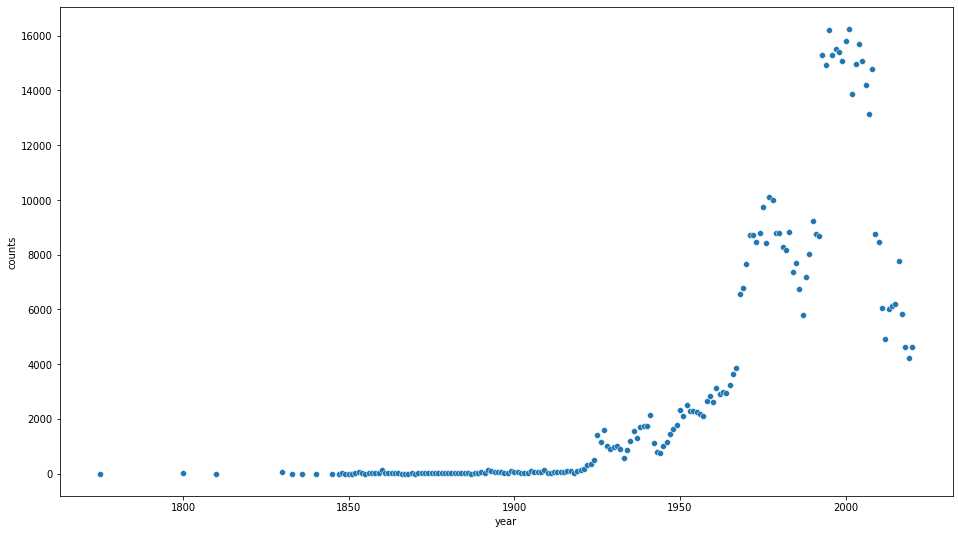

In [11]:
graph.figure(figsize=(16, 9))
sns.scatterplot(year_sums.index, year_sums['counts'])
graph.show()

In [12]:
fish_df['counts'] = fish_df[fish_df.columns[2:]].sum(axis=1)
fish_df.sort_values(by='counts', ascending=False, inplace=True)
fish_df

,made_up_code_merged,year,ablennes_hians,abudefduf_saxatilis,acantharchus_pomotis,acanthocybium_solandri,acantholiparis_opercularis,acantholumpenus_mackayi,acanthostracion_polygonius,acanthuridae_spp,...,zaprora_silenus,zaproridae_spp,zeidae_spp,zenion_hololepis,zenopsis_conchifer,zesticelus_profundorum,zoarces_americanus,zoarcidae_spp,zu_cristatus,counts
32107,CANUS_HYD_7.0,2005.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.0
32226,CANUS_HYD_9.0,1946.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.0
32060,CANUS_HYD_8.0,1982.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0
32258,CANUS_HYD_9.0,1941.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0
184089,CANUS_HYD_1055884.0,2008.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185916,CA_HYD_650541.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
187570,CA_HYD_930625.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
187569,C_BC_S_003673,-999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
185923,C_BC_S_001728,-999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [13]:
fish_df.loc[fish_df['counts'] == 0]

,made_up_code_merged,year,ablennes_hians,abudefduf_saxatilis,acantharchus_pomotis,acanthocybium_solandri,acantholiparis_opercularis,acantholumpenus_mackayi,acanthostracion_polygonius,acanthuridae_spp,...,zaprora_silenus,zaproridae_spp,zeidae_spp,zenion_hololepis,zenopsis_conchifer,zesticelus_profundorum,zoarces_americanus,zoarcidae_spp,zu_cristatus,counts
184673,C_BC_S_000284,-999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
184821,C_BC_S_000458,-999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
184863,C_BC_S_000506,-999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
184440,C_BC_S_000010,-999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
14,C_QC_S_000014,2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185916,CA_HYD_650541.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
187570,CA_HYD_930625.0,-999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
187569,C_BC_S_003673,-999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
185923,C_BC_S_001728,-999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


# Making Locations Database

In [18]:
canada_locations = pd.read_csv('/mnt/c/Users/imrit/Desktop/GEnfish_locations_ids_jan_14_2022.csv')
us_location = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project//US_hydrolakes_lake_caracteristics_oct_04.csv')

final_used_locs = pd.read_csv('/mnt/c/Users/imrit/Desktop/GENFISH_canada_us_lakes_jan_14_2022.csv')

display(canada_locations)
display(us_location)
display(final_used_locs)

/home/arshad/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (6,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/arshad/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (2,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,latitude,longitude,hydro_match,hydro_dist,Hylak_id,ocean,match2river,river_hydro_dist,river_hydro_id,hydro_waterbody,lake_name,made_up_code
0,45.095566,-74.434094,"[0.0, 754]",0.0,754.0,NO,NaN,NaN,NaN,lake,NaN,CA_HYD_754.0
1,44.488300,-86.332200,"[0.0, 6]",0.0,6.0,NO,NaN,NaN,NaN,lake,NaN,CA_HYD_6.0
2,45.669600,-83.887600,"[0.0, 8]",0.0,8.0,NO,NaN,NaN,NaN,lake,NaN,CA_HYD_8.0
3,45.200000,-85.656700,"[0.0, 6]",0.0,6.0,NO,NaN,NaN,NaN,lake,NaN,CA_HYD_6.0
4,45.510000,-81.146200,"[0.0, 8]",0.0,8.0,NO,NaN,NaN,NaN,lake,NaN,CA_HYD_8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
957427,61.693130,-150.312200,"[nan, nan]",NaN,NaN,NO,"[nan, nan]",NaN,NaN,NaN,NaN,NaN
957428,60.056000,-151.663100,"[nan, nan]",NaN,NaN,NO,"[nan, nan]",NaN,NaN,NaN,NaN,NaN
957429,61.534090,-149.267000,"[nan, nan]",NaN,NaN,NO,"[nan, nan]",NaN,NaN,NaN,NaN,NaN
957430,59.457950,-139.571400,"[nan, nan]",NaN,NaN,NO,"[nan, nan]",NaN,NaN,NaN,NaN,NaN


,latitude,longitude,hydro_id,ocean,hydro_dist,Hylak_id,Lake_name,Country,Continent,Poly_src,...,Vol_res,Vol_src,Depth_avg,Dis_avg,Res_time,Elevation,Slope_100,Wshd_area,Pour_long,Pour_lat
0,45.01527,-71.632880,109510.0,NO,0.000000,109510.0,NaN,United States of America,North America,SWBD,...,0.0,3.0,9.5,1.004,238.9,390.0,5.36,45.1,-71.615685,45.011404
1,47.21893,-69.574935,106047.0,NO,0.000000,106047.0,NaN,United States of America,North America,SWBD,...,0.0,3.0,12.0,3.545,275.5,322.0,4.70,181.1,-69.528058,47.162226
2,49.07637,-119.518180,8219.0,NO,73.063122,8219.0,Osoyoos Lake,United States of America,North America,SWBD,...,67.8,3.0,13.8,34.776,103.4,277.0,3.21,8177.1,-119.431149,48.952613
3,41.56480,-82.790000,9.0,NO,0.000000,9.0,Erie,United States of America,North America,SWBD,...,0.0,1.0,19.4,9796.883,589.5,172.0,-1.00,679903.4,-78.908084,42.904334
4,41.56080,-82.783500,9.0,NO,0.000000,9.0,Erie,United States of America,North America,SWBD,...,0.0,1.0,19.4,9796.883,589.5,172.0,-1.00,679903.4,-78.908084,42.904334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91690,43.77100,-79.142400,7.0,NO,211.608253,7.0,Ontario,United States of America,North America,SWBD,...,29960.0,1.0,84.8,7745.819,2450.5,73.0,-1.00,766137.4,-75.794246,44.480557
91691,43.82600,-79.088600,7.0,NO,456.711406,7.0,Ontario,United States of America,North America,SWBD,...,29960.0,1.0,84.8,7745.819,2450.5,73.0,-1.00,766137.4,-75.794246,44.480557
91692,43.82230,-79.072600,7.0,NO,432.277693,7.0,Ontario,United States of America,North America,SWBD,...,29960.0,1.0,84.8,7745.819,2450.5,73.0,-1.00,766137.4,-75.794246,44.480557
91693,43.62210,-79.482700,7.0,NO,120.735138,7.0,Ontario,United States of America,North America,SWBD,...,29960.0,1.0,84.8,7745.819,2450.5,73.0,-1.00,766137.4,-75.794246,44.480557


,latitude,longitude,hydro_match,hydro_dist,hydro_waterbody,Hylak_id,Country,Continent,made_up_code,country_code,hyd_code,made_up_code_merged
0,45.095566,-74.434094,"[0.0, 754]",0.000000,lake,754.0,NaN,NaN,CA_HYD_754.0,CA,HYD_754.0,CA_HYD_754.0
1,44.488300,-86.332200,"[0.0, 6]",0.000000,lake,6.0,NaN,NaN,CA_HYD_6.0,CA,HYD_6.0,CANUS_HYD_6.0
2,45.669600,-83.887600,"[0.0, 8]",0.000000,lake,8.0,NaN,NaN,CA_HYD_8.0,CA,HYD_8.0,CANUS_HYD_8.0
3,45.200000,-85.656700,"[0.0, 6]",0.000000,lake,6.0,NaN,NaN,CA_HYD_6.0,CA,HYD_6.0,CANUS_HYD_6.0
4,45.510000,-81.146200,"[0.0, 8]",0.000000,lake,8.0,NaN,NaN,CA_HYD_8.0,CA,HYD_8.0,CANUS_HYD_8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
265839,43.771000,-79.142400,NaN,211.608253,lake,7.0,United States of America,North America,US_HYD_7.0,US,HYD_7.0,CANUS_HYD_7.0
265840,43.826000,-79.088600,NaN,456.711406,lake,7.0,United States of America,North America,US_HYD_7.0,US,HYD_7.0,CANUS_HYD_7.0
265841,43.822300,-79.072600,NaN,432.277693,lake,7.0,United States of America,North America,US_HYD_7.0,US,HYD_7.0,CANUS_HYD_7.0
265842,43.622100,-79.482700,NaN,120.735138,lake,7.0,United States of America,North America,US_HYD_7.0,US,HYD_7.0,CANUS_HYD_7.0


In [19]:
canada_us_locs = pd.concat([canada_locations, us_location])
canada_us_locs = canada_us_locs.merge(final_used_locs, on=['latitude', 'longitude'])

canada_us_locs

,latitude,longitude,hydro_match_x,hydro_dist_x,Hylak_id_x,ocean,match2river,river_hydro_dist,river_hydro_id,hydro_waterbody_x,...,hydro_match_y,hydro_dist_y,hydro_waterbody_y,Hylak_id_y,Country_y,Continent_y,made_up_code_y,country_code,hyd_code,made_up_code_merged
0,45.095566,-74.434094,"[0.0, 754]",0.0,754.0,NO,NaN,NaN,NaN,lake,...,"[0.0, 754]",0.0,lake,754.0,NaN,NaN,CA_HYD_754.0,CA,HYD_754.0,CA_HYD_754.0
1,44.488300,-86.332200,"[0.0, 6]",0.0,6.0,NO,NaN,NaN,NaN,lake,...,"[0.0, 6]",0.0,lake,6.0,NaN,NaN,CA_HYD_6.0,CA,HYD_6.0,CANUS_HYD_6.0
2,44.488300,-86.332200,"[0.0, 6]",0.0,6.0,NO,NaN,NaN,NaN,lake,...,NaN,0.0,lake,6.0,United States of America,North America,US_HYD_6.0,US,HYD_6.0,CANUS_HYD_6.0
3,44.488300,-86.332200,NaN,0.0,6.0,NO,NaN,NaN,NaN,NaN,...,"[0.0, 6]",0.0,lake,6.0,NaN,NaN,CA_HYD_6.0,CA,HYD_6.0,CANUS_HYD_6.0
4,44.488300,-86.332200,NaN,0.0,6.0,NO,NaN,NaN,NaN,NaN,...,NaN,0.0,lake,6.0,United States of America,North America,US_HYD_6.0,US,HYD_6.0,CANUS_HYD_6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439924,43.083333,-80.433333,"[nan, nan]",NaN,NaN,NO,"[nan, nan]",NaN,NaN,NaN,...,"[nan, nan]",NaN,lake,NaN,NaN,NaN,CA_ON_AHI_BSM_9838,CA,ON_AHI,CA_ON_AHI_BSM_9838
439925,42.938611,-80.551944,"[nan, nan]",NaN,NaN,NO,"[nan, nan]",NaN,NaN,NaN,...,"[nan, nan]",NaN,lake,NaN,NaN,NaN,CA_ON_AHI_BSM_17,CA,ON_AHI,CA_ON_AHI_BSM_17
439926,43.365000,-80.930833,"[nan, nan]",NaN,NaN,NO,"[nan, nan]",NaN,NaN,NaN,...,"[nan, nan]",NaN,lake,NaN,NaN,NaN,CA_ON_AHI_BSM_62,CA,ON_AHI,CA_ON_AHI_BSM_62
439927,44.044444,-81.368056,"[nan, nan]",NaN,NaN,NO,"[nan, nan]",NaN,NaN,NaN,...,"[nan, nan]",NaN,lake,NaN,NaN,NaN,CA_ON_AHI_BSM_195,CA,ON_AHI,CA_ON_AHI_BSM_195


In [20]:
len(canada_us_locs['made_up_code_merged'].unique())

37421

In [10]:
final_used_locs = pd.read_csv('/mnt/c/Users/imrit/Desktop/GENFISH_canada_us_lakes_jan_14_2022.csv')
final_used_locs['Hylak_id'].fillna(final_used_locs['hydro_id'], inplace=True)

final_used_locs.drop(columns = ['hydro_match', 'hydro_dist', 'match2river', 'river_hydro_dist', 
                                'river_hydro_id', 'Continent', 'hyd_code', 'Country', 'hydro_waterbody', 'hydro_id', 
                                'Lake_name', 'Poly_src', 'Lake_type', 'Grand_id',
       'Lake_area', 'Shore_len', 'Shore_dev', 'Vol_total', 'Vol_res',
       'Vol_src', 'Depth_avg', 'Dis_avg', 'Res_time', 'Elevation', 'Slope_100',
       'Wshd_area', 'Pour_long', 'Pour_lat', 'made_up_code', 'ocean'], 
                     inplace=True)

final_used_locs.drop_duplicates(inplace=True)
final_used_locs['country_code'] = final_used_locs['made_up_code_merged'].str.split('_').str.get(0)

display(final_used_locs)
print(len(final_used_locs['made_up_code_merged'].unique()))

/home/arshad/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (2,6,10,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,latitude,longitude,Hylak_id,lake_name,country_code,made_up_code_merged
0,45.095566,-74.434094,754.0,NaN,CA,CA_HYD_754.0
1,44.488300,-86.332200,6.0,NaN,CANUS,CANUS_HYD_6.0
2,45.669600,-83.887600,8.0,NaN,CANUS,CANUS_HYD_8.0
3,45.200000,-85.656700,6.0,NaN,CANUS,CANUS_HYD_6.0
4,45.510000,-81.146200,8.0,NaN,CANUS,CANUS_HYD_8.0
...,...,...,...,...,...,...
265839,43.771000,-79.142400,7.0,NaN,CANUS,CANUS_HYD_7.0
265840,43.826000,-79.088600,7.0,NaN,CANUS,CANUS_HYD_7.0
265841,43.822300,-79.072600,7.0,NaN,CANUS,CANUS_HYD_7.0
265842,43.622100,-79.482700,7.0,NaN,CANUS,CANUS_HYD_7.0


39101


In [11]:
hydrolakes_df = pd.read_csv('/mnt/c/Users/imrit/Downloads/HydroLAKES_polys_v10/HydroLAKES_polys_v10_shp/hydrolakes_v10.csv')
print(len(hydrolakes_df))
display(hydrolakes_df.head())

/home/arshad/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1427688


,Hylak_id,Lake_name,Country,Continent,Poly_src,Lake_type,Grand_id,Lake_area,Shore_len,Shore_dev,...,Vol_res,Vol_src,Depth_avg,Dis_avg,Res_time,Elevation,Slope_100,Wshd_area,Pour_long,Pour_lat
0,1,Caspian Sea,Russia,Europe,SWBD,1,0,377001.91,15829.37,7.27,...,0.0,1,200.5,8110.642,107883.0,-29,-1.0,1404108.0,47.717708,45.591934
1,2,Great Bear,Canada,North America,CanVec,1,0,30450.64,5331.72,8.62,...,0.0,1,72.2,535.187,47577.7,145,-1.0,147665.4,-123.505546,65.138384
2,3,Great Slave,Canada,North America,CanVec,1,0,26734.29,9814.16,16.93,...,0.0,1,59.1,4350.692,4203.2,148,-1.0,995312.3,-117.617115,61.311727
3,4,Winnipeg,Canada,North America,CanVec,3,709,23923.04,4018.32,7.33,...,31790.0,1,11.9,2244.727,1464.3,215,-1.0,919611.5,-97.863542,53.696359
4,5,Superior,United States of America,North America,SWBD,1,0,81843.92,5248.36,5.18,...,0.0,1,146.7,2869.953,48410.3,179,-1.0,209219.5,-84.460547,46.468593


In [12]:
locs_hydro_merged = final_used_locs.merge(hydrolakes_df, on=['Hylak_id'], how='left')

locs_hydro_merged.rename(columns = {'Lake_area': 'surface_area_km2', 'Shore_len': 'shore_len_km', 
                                    'Vol_total': 'vol_total_mcm', 'Depth_avg': 'depth_avg_m', 'Elevation': 'elevation_m'}, 
                         inplace=True )
display(locs_hydro_merged)

,latitude,longitude,Hylak_id,lake_name,country_code,made_up_code_merged,Lake_name,Country,Continent,Poly_src,...,Vol_res,Vol_src,depth_avg_m,Dis_avg,Res_time,elevation_m,Slope_100,Wshd_area,Pour_long,Pour_lat
0,45.095566,-74.434094,754.0,NaN,CA,CA_HYD_754.0,St. Francis,Canada,North America,CanVec,...,0.0,3.0,3.4,8060.090,1.2,43.0,0.62,781910.1,-74.168641,45.268507
1,44.488300,-86.332200,6.0,NaN,CANUS,CANUS_HYD_6.0,Michigan,United States of America,North America,SWBD,...,0.0,1.0,84.2,1877.753,29956.0,175.0,-1.00,176006.4,-84.753910,45.822916
2,45.669600,-83.887600,8.0,NaN,CANUS,CANUS_HYD_8.0,Huron,United States of America,North America,SWBD,...,0.0,1.0,59.8,9162.152,4484.5,175.0,-1.00,576017.7,-82.422576,42.999403
3,45.200000,-85.656700,6.0,NaN,CANUS,CANUS_HYD_6.0,Michigan,United States of America,North America,SWBD,...,0.0,1.0,84.2,1877.753,29956.0,175.0,-1.00,176006.4,-84.753910,45.822916
4,45.510000,-81.146200,8.0,NaN,CANUS,CANUS_HYD_8.0,Huron,United States of America,North America,SWBD,...,0.0,1.0,59.8,9162.152,4484.5,175.0,-1.00,576017.7,-82.422576,42.999403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265726,43.771000,-79.142400,7.0,NaN,CANUS,CANUS_HYD_7.0,Ontario,United States of America,North America,SWBD,...,29960.0,1.0,84.8,7745.819,2450.5,73.0,-1.00,766137.4,-75.794246,44.480557
265727,43.826000,-79.088600,7.0,NaN,CANUS,CANUS_HYD_7.0,Ontario,United States of America,North America,SWBD,...,29960.0,1.0,84.8,7745.819,2450.5,73.0,-1.00,766137.4,-75.794246,44.480557
265728,43.822300,-79.072600,7.0,NaN,CANUS,CANUS_HYD_7.0,Ontario,United States of America,North America,SWBD,...,29960.0,1.0,84.8,7745.819,2450.5,73.0,-1.00,766137.4,-75.794246,44.480557
265729,43.622100,-79.482700,7.0,NaN,CANUS,CANUS_HYD_7.0,Ontario,United States of America,North America,SWBD,...,29960.0,1.0,84.8,7745.819,2450.5,73.0,-1.00,766137.4,-75.794246,44.480557


In [13]:
locs_hydro_merged['Pour_lat'].fillna(locs_hydro_merged['latitude'], inplace=True)
locs_hydro_merged['Pour_long'].fillna(locs_hydro_merged['longitude'], inplace=True)

locs_hydro_merged.drop(columns=['latitude', 'longitude'], inplace=True)
locs_hydro_merged.drop_duplicates(subset = [col for col in locs_hydro_merged if col != 'lake_name'], inplace=True)
display(locs_hydro_merged)

,Hylak_id,lake_name,country_code,made_up_code_merged,Lake_name,Country,Continent,Poly_src,Lake_type,Grand_id,...,Vol_res,Vol_src,depth_avg_m,Dis_avg,Res_time,elevation_m,Slope_100,Wshd_area,Pour_long,Pour_lat
0,754.0,NaN,CA,CA_HYD_754.0,St. Francis,Canada,North America,CanVec,1.0,0.0,...,0.0,3.0,3.4,8060.090,1.2,43.0,0.62,781910.1,-74.168641,45.268507
1,6.0,NaN,CANUS,CANUS_HYD_6.0,Michigan,United States of America,North America,SWBD,1.0,0.0,...,0.0,1.0,84.2,1877.753,29956.0,175.0,-1.00,176006.4,-84.753910,45.822916
2,8.0,NaN,CANUS,CANUS_HYD_8.0,Huron,United States of America,North America,SWBD,1.0,0.0,...,0.0,1.0,59.8,9162.152,4484.5,175.0,-1.00,576017.7,-82.422576,42.999403
5,5.0,NaN,CANUS,CANUS_HYD_5.0,Superior,United States of America,North America,SWBD,1.0,0.0,...,0.0,1.0,146.7,2869.953,48410.3,179.0,-1.00,209219.5,-84.460547,46.468593
22,104335.0,NaN,CANUS,CANUS_HYD_104335.0,NaN,United States of America,North America,SWBD,1.0,0.0,...,0.0,3.0,16.5,1.940,761.0,446.0,6.60,120.7,-90.099084,48.058980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258675,1069642.0,NaN,US,US_HYD_1069642.0,NaN,United States of America,North America,SWBD,1.0,0.0,...,0.0,3.0,1.2,1.897,1.1,4.0,0.32,303.2,-80.425730,25.261480
264341,1054171.0,NaN,US,US_HYD_1054171.0,NaN,United States of America,North America,SWBD,1.0,0.0,...,0.0,3.0,3.1,0.031,670.8,-9.0,1.36,1.3,-70.452706,41.360175
264893,114681.0,NaN,US,US_HYD_114681.0,NaN,United States of America,North America,SWBD,1.0,0.0,...,0.0,3.0,1.0,1.377,10.0,2.0,0.48,150.2,-80.596875,25.207381
265396,1066785.0,NaN,US,US_HYD_1066785.0,NaN,United States of America,North America,SWBD,1.0,0.0,...,0.0,3.0,1.5,0.255,59.5,0.0,0.27,10.8,-91.423635,29.593778


In [14]:
locs_hydro_merged['country_code'] = locs_hydro_merged['made_up_code_merged'].str.split('_').str.get(0)
locs_hydro_merged['country_code'].value_counts()

CA       22396
CANUS    14252
C         2426
US          27
Name: country_code, dtype: int64

In [15]:
sapna_lakes = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/sapna_lakes_lat_longs_hydro_match.csv')
sapna_lakes = sapna_lakes.loc[sapna_lakes['hydro_dist'].isna()]

locs_hydro_merged_sapna = locs_hydro_merged.merge(sapna_lakes, left_on = 'made_up_code_merged', right_on = 'made_up_code', 
                                                  how='left').drop(columns=['made_up_code', 'hydro_match', 
                                                                            'hydro_dist', 'hydro_id', 'latitude', 'longitude'])

locs_hydro_merged_sapna['country_code'] = locs_hydro_merged_sapna['made_up_code_merged'].str.split('_').str.get(0)

locs_hydro_merged_sapna['country_code'] = np.where(locs_hydro_merged_sapna['Country'] == 'United States of America', 'US', 
                                             locs_hydro_merged_sapna['country_code'])

display(locs_hydro_merged_sapna)

,Hylak_id,lake_name_x,country_code,made_up_code_merged,Lake_name,Country,Continent,Poly_src,Lake_type,Grand_id,...,Res_time,elevation_m,Slope_100,Wshd_area,Pour_long,Pour_lat,lake_name_y,surface_area_ha,max_depth_m,mean_depth_m
0,754.0,NaN,CA,CA_HYD_754.0,St. Francis,Canada,North America,CanVec,1.0,0.0,...,1.2,43.0,0.62,781910.1,-74.168641,45.268507,NaN,NaN,NaN,NaN
1,6.0,NaN,US,CANUS_HYD_6.0,Michigan,United States of America,North America,SWBD,1.0,0.0,...,29956.0,175.0,-1.00,176006.4,-84.753910,45.822916,NaN,NaN,NaN,NaN
2,8.0,NaN,US,CANUS_HYD_8.0,Huron,United States of America,North America,SWBD,1.0,0.0,...,4484.5,175.0,-1.00,576017.7,-82.422576,42.999403,NaN,NaN,NaN,NaN
3,5.0,NaN,US,CANUS_HYD_5.0,Superior,United States of America,North America,SWBD,1.0,0.0,...,48410.3,179.0,-1.00,209219.5,-84.460547,46.468593,NaN,NaN,NaN,NaN
4,104335.0,NaN,US,CANUS_HYD_104335.0,NaN,United States of America,North America,SWBD,1.0,0.0,...,761.0,446.0,6.60,120.7,-90.099084,48.058980,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39096,1069642.0,NaN,US,US_HYD_1069642.0,NaN,United States of America,North America,SWBD,1.0,0.0,...,1.1,4.0,0.32,303.2,-80.425730,25.261480,NaN,NaN,NaN,NaN
39097,1054171.0,NaN,US,US_HYD_1054171.0,NaN,United States of America,North America,SWBD,1.0,0.0,...,670.8,-9.0,1.36,1.3,-70.452706,41.360175,NaN,NaN,NaN,NaN
39098,114681.0,NaN,US,US_HYD_114681.0,NaN,United States of America,North America,SWBD,1.0,0.0,...,10.0,2.0,0.48,150.2,-80.596875,25.207381,NaN,NaN,NaN,NaN
39099,1066785.0,NaN,US,US_HYD_1066785.0,NaN,United States of America,North America,SWBD,1.0,0.0,...,59.5,0.0,0.27,10.8,-91.423635,29.593778,NaN,NaN,NaN,NaN


In [16]:
locs_hydro_merged_sapna['surface_area_km2'].fillna(locs_hydro_merged_sapna['surface_area_ha']*0.01, inplace=True)
locs_hydro_merged_sapna['depth_avg_m'].fillna(locs_hydro_merged_sapna['mean_depth_m'], inplace=True)

locs_hydro_merged_sapna.drop(columns = ['surface_area_ha', 'mean_depth_m'], inplace=True)

In [17]:
locs_hydro_merged_sapna.loc[locs_hydro_merged_sapna['made_up_code_merged'].str.contains('AHI')]

,Hylak_id,lake_name_x,country_code,made_up_code_merged,Lake_name,Country,Continent,Poly_src,Lake_type,Grand_id,...,depth_avg_m,Dis_avg,Res_time,elevation_m,Slope_100,Wshd_area,Pour_long,Pour_lat,lake_name_y,max_depth_m
4798,NaN,Strong L.,CA,CA_ON_AHI_BSM_1331,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-77.141389,45.107480,NaN,NaN
4801,NaN,Nicholson L.,CA,CA_ON_AHI_BSM_1367,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-76.693611,45.120833,NaN,NaN
4808,NaN,Rose L.,CA,CA_ON_AHI_BSM_1431,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-77.218611,45.146667,NaN,NaN
4809,NaN,Green L.,CA,CA_ON_AHI_BSM_1418,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-76.608333,45.142500,NaN,NaN
4811,NaN,Mistry L.,CA,CA_ON_AHI_BSM_1319,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-77.423889,45.101389,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32592,NaN,Sawdust L.,CA,CA_ON_AHI_BSM_6348,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-80.837778,48.648611,NaN,NaN
32593,NaN,Beaver L.,CA,CA_ON_AHI_BSM_5988,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-81.316667,48.366667,NaN,NaN
32596,NaN,Bow L.,CA,CA_ON_AHI_BSM_6015,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-80.783056,48.387222,NaN,NaN
32600,NaN,"30, L.",CA,CA_ON_AHI_BSM_5926,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-80.595556,48.317778,NaN,NaN


In [18]:
locs_hydro_merged_sapna.loc[locs_hydro_merged_sapna['country_code'] == 'C']

,Hylak_id,lake_name_x,country_code,made_up_code_merged,Lake_name,Country,Continent,Poly_src,Lake_type,Grand_id,...,depth_avg_m,Dis_avg,Res_time,elevation_m,Slope_100,Wshd_area,Pour_long,Pour_lat,lake_name_y,max_depth_m
4715,NaN,NaN,C,C_BC_S_003667,NaN,NaN,NaN,NaN,NaN,NaN,...,4.5,NaN,NaN,NaN,NaN,NaN,-119.255077,51.648376,NaN,11.0
4716,NaN,NaN,C,C_BC_S_003668,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,-123.212935,54.941344,NaN,6.0
4719,NaN,NaN,C,C_BC_S_003671,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-130.143091,59.221439,NaN,NaN
4720,NaN,NaN,C,C_BC_S_003673,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-123.243288,50.247745,NaN,9.6
4722,NaN,NaN,C,C_BC_S_003675,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-121.925854,58.155383,NaN,7.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12060,NaN,NaN,C,C_BC_S_002755,NaN,NaN,NaN,NaN,NaN,NaN,...,2.6,NaN,NaN,NaN,NaN,NaN,-126.185064,59.952940,NaN,5.0
12062,NaN,NaN,C,C_BC_S_002757,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,-121.484215,58.527403,NaN,4.9
12063,NaN,NaN,C,C_BC_S_002759,NaN,NaN,NaN,NaN,NaN,NaN,...,4.1,NaN,NaN,NaN,NaN,NaN,-120.100996,52.336774,NaN,7.0
12065,NaN,NaN,C,C_BC_S_002761,NaN,NaN,NaN,NaN,NaN,NaN,...,3.2,NaN,NaN,NaN,NaN,NaN,-121.691631,58.735701,NaN,4.6


In [19]:
ahi = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Analysis/Range_shifts/Ontario/Data/ahi_unique_lakes.csv')
bsm = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Analysis/Range_shifts/Ontario/Data/BSM_unique_lakes.csv')

ontario_lakes = pd.concat([ahi, bsm])

# ['wby_name', 'latitude', 'longitude', 'alt_name', 'surface_area_ha', 'max_depth',
#        'mean_depth', 'lake_elevation_(m)', 'surface_water_temp', 'conductivity_(us/cm)',
#        'secchi_depth_(m)', 'tds_(mg/l)', 'ph', 'o2']

# ontario_lakes = ontario_lakes[['wby_name', 'latitude', 'longitude']]
ontario_lakes.rename(columns = {'wby_name': 'lake_name'}, inplace = True)
ontario_lakes.drop_duplicates(inplace=True)

ontario_lakes.reset_index(drop = True, inplace = True)

ontario_lakes['index_val'] = ontario_lakes.index
ontario_lakes['index_val'] = ontario_lakes['index_val'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)
ontario_lakes['made_up_code'] = 'C_ON_U_' + ontario_lakes['index_val']

ontario_lakes = ontario_lakes[['latitude', 'longitude', 'made_up_code', 'lake_name', 
                               'surface_area_ha', 'max_depth', 'mean_depth', 'lake_elevation_(m)']]

print(len(ontario_lakes))
ontario_lakes.head()

10730


/home/arshad/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,latitude,longitude,made_up_code,lake_name,surface_area_ha,max_depth,mean_depth,lake_elevation_(m)
0,42.126667,-83.120000,C_ON_U_000000,Duff L.,3.0,6.4,3.4,175.0
1,42.707778,-81.169722,C_ON_U_000001,Saunders P.,3.7,2.7,1.0,214.0
2,42.711667,-80.565833,C_ON_U_000002,Deer Cr. Re.,26.5,12.0,5.8,201.0
3,42.713333,-81.118889,C_ON_U_000003,Zavitz P.,2.9,2.4,0.6,236.0
4,42.726111,-80.318056,C_ON_U_000004,Mathers P.,1.3,1.8,0.9,224.0


In [20]:
hydro_sapna_ahi = locs_hydro_merged_sapna.merge(ontario_lakes, left_on = ['Pour_lat', 'Pour_long'], 
                                                right_on = ['latitude', 'longitude'], how='left').drop(columns=['latitude', 'longitude'])
hydro_sapna_ahi['depth_avg_m'].fillna(hydro_sapna_ahi['mean_depth'], inplace=True)
hydro_sapna_ahi['elevation_m'].fillna(hydro_sapna_ahi['lake_elevation_(m)'], inplace=True)
hydro_sapna_ahi['surface_area_km2'].fillna(hydro_sapna_ahi['surface_area_ha'] * 0.01, inplace=True)
hydro_sapna_ahi['max_depth_m'].fillna(hydro_sapna_ahi['max_depth'], inplace=True)

hydro_sapna_ahi.drop(columns = ['mean_depth', 'lake_elevation_(m)', 'surface_area_ha', 'made_up_code', 'max_depth'], 
                     inplace=True)

hydro_sapna_ahi.rename(columns = {'Pour_lat': 'latitude', 'Pour_long': 'longitude'}, inplace=True)
hydro_sapna_ahi['country_code'].replace('C', 'CA', inplace=True)

hydro_sapna_ahi

,Hylak_id,lake_name_x,country_code,made_up_code_merged,Lake_name,Country,Continent,Poly_src,Lake_type,Grand_id,...,Dis_avg,Res_time,elevation_m,Slope_100,Wshd_area,longitude,latitude,lake_name_y,max_depth_m,lake_name
0,754.0,NaN,CA,CA_HYD_754.0,St. Francis,Canada,North America,CanVec,1.0,0.0,...,8060.090,1.2,43.0,0.62,781910.1,-74.168641,45.268507,NaN,NaN,NaN
1,6.0,NaN,US,CANUS_HYD_6.0,Michigan,United States of America,North America,SWBD,1.0,0.0,...,1877.753,29956.0,175.0,-1.00,176006.4,-84.753910,45.822916,NaN,NaN,NaN
2,8.0,NaN,US,CANUS_HYD_8.0,Huron,United States of America,North America,SWBD,1.0,0.0,...,9162.152,4484.5,175.0,-1.00,576017.7,-82.422576,42.999403,NaN,NaN,NaN
3,5.0,NaN,US,CANUS_HYD_5.0,Superior,United States of America,North America,SWBD,1.0,0.0,...,2869.953,48410.3,179.0,-1.00,209219.5,-84.460547,46.468593,NaN,NaN,NaN
4,104335.0,NaN,US,CANUS_HYD_104335.0,NaN,United States of America,North America,SWBD,1.0,0.0,...,1.940,761.0,446.0,6.60,120.7,-90.099084,48.058980,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39100,1069642.0,NaN,US,US_HYD_1069642.0,NaN,United States of America,North America,SWBD,1.0,0.0,...,1.897,1.1,4.0,0.32,303.2,-80.425730,25.261480,NaN,NaN,NaN
39101,1054171.0,NaN,US,US_HYD_1054171.0,NaN,United States of America,North America,SWBD,1.0,0.0,...,0.031,670.8,-9.0,1.36,1.3,-70.452706,41.360175,NaN,NaN,NaN
39102,114681.0,NaN,US,US_HYD_114681.0,NaN,United States of America,North America,SWBD,1.0,0.0,...,1.377,10.0,2.0,0.48,150.2,-80.596875,25.207381,NaN,NaN,NaN
39103,1066785.0,NaN,US,US_HYD_1066785.0,NaN,United States of America,North America,SWBD,1.0,0.0,...,0.255,59.5,0.0,0.27,10.8,-91.423635,29.593778,NaN,NaN,NaN


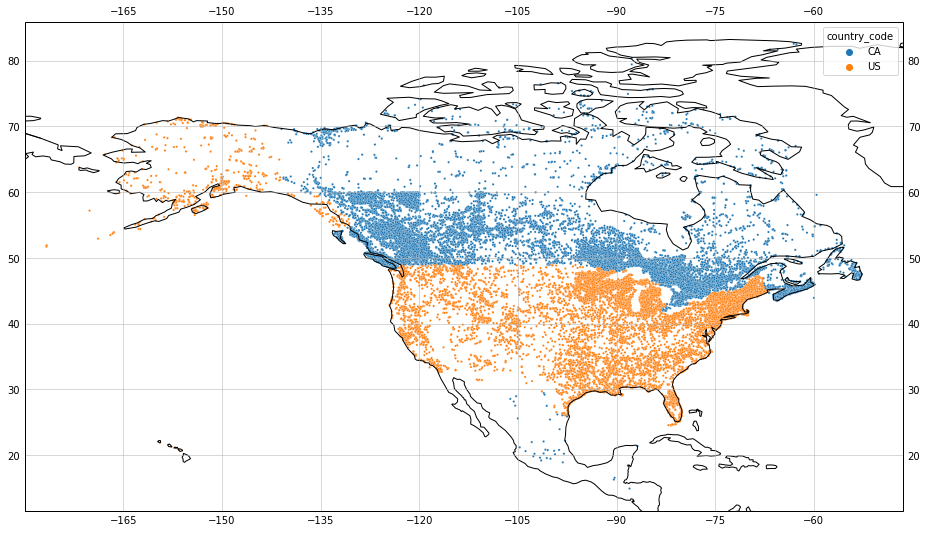

CPU times: user 2.36 s, sys: 859 ms, total: 3.22 s
Wall time: 2.08 s


In [21]:
%%time
graph.figure(figsize=(16, 9))
ax = graph.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, linewidth = 0.5)

sns.scatterplot(hydro_sapna_ahi['longitude'], hydro_sapna_ahi['latitude'],
                transform=ccrs.PlateCarree(), s=5, hue=hydro_sapna_ahi['country_code'])

# resol = '50m'
# provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
#     name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k')
# ax.add_feature(provinc_bodr, linestyle='--', linewidth=0.2, edgecolor="k", zorder=10)

# graph.legend([], [], frameon=False)
# ax.figure.savefig('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Graphs/canadian_lakes_locations_aug_25.png')
graph.show()


In [22]:
hydro_sapna_ahi['lake_code'] = (hydro_sapna_ahi['country_code'] + '_' + 
                                hydro_sapna_ahi['made_up_code_merged'].str.split('_', n=1).str.get(1))
hydro_sapna_ahi

,Hylak_id,lake_name_x,country_code,made_up_code_merged,Lake_name,Country,Continent,Poly_src,Lake_type,Grand_id,...,Res_time,elevation_m,Slope_100,Wshd_area,longitude,latitude,lake_name_y,max_depth_m,lake_name,lake_code
0,754.0,NaN,CA,CA_HYD_754.0,St. Francis,Canada,North America,CanVec,1.0,0.0,...,1.2,43.0,0.62,781910.1,-74.168641,45.268507,NaN,NaN,NaN,CA_HYD_754.0
1,6.0,NaN,US,CANUS_HYD_6.0,Michigan,United States of America,North America,SWBD,1.0,0.0,...,29956.0,175.0,-1.00,176006.4,-84.753910,45.822916,NaN,NaN,NaN,US_HYD_6.0
2,8.0,NaN,US,CANUS_HYD_8.0,Huron,United States of America,North America,SWBD,1.0,0.0,...,4484.5,175.0,-1.00,576017.7,-82.422576,42.999403,NaN,NaN,NaN,US_HYD_8.0
3,5.0,NaN,US,CANUS_HYD_5.0,Superior,United States of America,North America,SWBD,1.0,0.0,...,48410.3,179.0,-1.00,209219.5,-84.460547,46.468593,NaN,NaN,NaN,US_HYD_5.0
4,104335.0,NaN,US,CANUS_HYD_104335.0,NaN,United States of America,North America,SWBD,1.0,0.0,...,761.0,446.0,6.60,120.7,-90.099084,48.058980,NaN,NaN,NaN,US_HYD_104335.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39100,1069642.0,NaN,US,US_HYD_1069642.0,NaN,United States of America,North America,SWBD,1.0,0.0,...,1.1,4.0,0.32,303.2,-80.425730,25.261480,NaN,NaN,NaN,US_HYD_1069642.0
39101,1054171.0,NaN,US,US_HYD_1054171.0,NaN,United States of America,North America,SWBD,1.0,0.0,...,670.8,-9.0,1.36,1.3,-70.452706,41.360175,NaN,NaN,NaN,US_HYD_1054171.0
39102,114681.0,NaN,US,US_HYD_114681.0,NaN,United States of America,North America,SWBD,1.0,0.0,...,10.0,2.0,0.48,150.2,-80.596875,25.207381,NaN,NaN,NaN,US_HYD_114681.0
39103,1066785.0,NaN,US,US_HYD_1066785.0,NaN,United States of America,North America,SWBD,1.0,0.0,...,59.5,0.0,0.27,10.8,-91.423635,29.593778,NaN,NaN,NaN,US_HYD_1066785.0


In [23]:
hydro_sapna_ahi['country_code'].value_counts(dropna=False)

CA    24127
US    14978
Name: country_code, dtype: int64

In [227]:
hydro_sapna_ahi_subset = hydro_sapna_ahi[['made_up_code_merged', 'latitude', 'longitude', 'lake_code', 'country_code']]
hydro_sapna_ahi.drop(columns = ['made_up_code_merged'], inplace=True)
hydro_sapna_ahi.to_csv('/mnt/c/Users/imrit/Desktop/GENFISH_lake_morphologies.csv', index=False)

In [206]:
%%time
fish_df = pd.read_csv('/mnt/c/Users/imrit/Desktop/canada_us_fish_occurence.csv')
fish_df.head()

,made_up_code_merged,year,ablennes_hians,abudefduf_saxatilis,acantharchus_pomotis,acanthocybium_solandri,acantholiparis_opercularis,acantholumpenus_mackayi,acanthostracion_polygonius,acanthuridae_spp,...,zaniolepis_latipinnis,zaprora_silenus,zaproridae_spp,zeidae_spp,zenion_hololepis,zenopsis_conchifer,zesticelus_profundorum,zoarces_americanus,zoarcidae_spp,zu_cristatus
0,CA_HYD_1038221.0,2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CA_HYD_1037525.0,2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CA_HYD_1038157.0,2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CA_HYD_1037792.0,2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CA_HYD_1038820.0,2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [209]:
print(len(fish_df))
print(len(fish_df['made_up_code_merged'].unique()))

190036
38458


In [213]:
fish_df_lat_long = fish_df.merge(hydro_sapna_ahi_subset).drop(columns = ['made_up_code_merged'])
display(fish_df_lat_long)

,year,ablennes_hians,abudefduf_saxatilis,acantharchus_pomotis,acanthocybium_solandri,acantholiparis_opercularis,acantholumpenus_mackayi,acanthostracion_polygonius,acanthuridae_spp,acanthurus_bahianus,...,zenion_hololepis,zenopsis_conchifer,zesticelus_profundorum,zoarces_americanus,zoarcidae_spp,zu_cristatus,latitude,longitude,lake_code,country_code
0,2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,45.360142,-66.630287,CA_HYD_1038221.0,CA
1,2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,45.446826,-66.677070,CA_HYD_1037525.0,CA
2,2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,45.368494,-66.723958,CA_HYD_1038157.0,CA
3,2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,45.414338,-66.717173,CA_HYD_1037792.0,CA
4,2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,45.297935,-66.668750,CA_HYD_1038820.0,CA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190035,2003.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,66.206171,-155.492708,US_HYD_398426.0,US
190036,2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,66.206171,-155.492708,US_HYD_398426.0,US
190037,2005.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,66.206171,-155.492708,US_HYD_398426.0,US
190038,2006.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,66.206171,-155.492708,US_HYD_398426.0,US


In [224]:
column_order = ['country_code', 'lake_code', 'latitude', 'longitude'] 
column_order.extend(fish_df.columns[1:])
column_order

['country_code',
 'lake_code',
 'latitude',
 'longitude',
 'year',
 'ablennes_hians',
 'abudefduf_saxatilis',
 'acantharchus_pomotis',
 'acanthocybium_solandri',
 'acantholiparis_opercularis',
 'acantholumpenus_mackayi',
 'acanthostracion_polygonius',
 'acanthuridae_spp',
 'acanthurus_bahianus',
 'acanthurus_chirurgus',
 'acanthurus_coeruleus',
 'acanthurus_spp',
 'acipenser_brevirostrum',
 'acipenser_carbonarius',
 'acipenser_fulvescens',
 'acipenser_medirostris',
 'acipenser_oxyrinchus',
 'acipenser_transmontanus',
 'acipenseridae_spp',
 'acrocheilus_alutaceus',
 'acropomatidae_spp',
 'agonidae_spp',
 'agonomalus_mozinoi',
 'agonopsis_vulsa',
 'agosia_chrysogaster',
 'ahlia_egmontis',
 'ahliesaurus_berryi',
 'albatrossia_pectoralis',
 'albula_vulpes',
 'aldrovandia_affinis',
 'aldrovandia_gracilis',
 'aldrovandia_phalacra',
 'alectis_ciliaris',
 'alepisauridae_spp',
 'alepisaurus_brevirostris',
 'alepisaurus_ferox',
 'alepocephalidae_spp',
 'alepocephalus_agassizii',
 'alepocephalus_

In [225]:
fish_df_lat_long = fish_df_lat_long[column_order]
fish_df_lat_long

,country_code,lake_code,latitude,longitude,year,ablennes_hians,abudefduf_saxatilis,acantharchus_pomotis,acanthocybium_solandri,acantholiparis_opercularis,...,zaniolepis_latipinnis,zaprora_silenus,zaproridae_spp,zeidae_spp,zenion_hololepis,zenopsis_conchifer,zesticelus_profundorum,zoarces_americanus,zoarcidae_spp,zu_cristatus
0,CA,CA_HYD_1038221.0,45.360142,-66.630287,2004.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CA,CA_HYD_1037525.0,45.446826,-66.677070,2004.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CA,CA_HYD_1038157.0,45.368494,-66.723958,2004.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CA,CA_HYD_1037792.0,45.414338,-66.717173,2004.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CA,CA_HYD_1038820.0,45.297935,-66.668750,2004.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190035,US,US_HYD_398426.0,66.206171,-155.492708,2003.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190036,US,US_HYD_398426.0,66.206171,-155.492708,2004.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190037,US,US_HYD_398426.0,66.206171,-155.492708,2005.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190038,US,US_HYD_398426.0,66.206171,-155.492708,2006.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [226]:
fish_df_lat_long.to_csv('/mnt/c/Users/imrit/Desktop/GENFISH_canada_us_locations.csv', index=False)

# Rechecking - Jan 21 2022

In [2]:
lake_locations = pd.read_csv('/mnt/c/Users/imrit/Desktop/GENFISH_upload/GENFISH_lake_morphologies.csv')
lake_locations

/home/arshad/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (1,23,25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Hylak_id,lake_name_x,country_code,Lake_name,Country,Continent,Poly_src,Lake_type,Grand_id,surface_area_km2,...,Res_time,elevation_m,Slope_100,Wshd_area,longitude,latitude,lake_name_y,max_depth_m,lake_name,lake_code
0,754.0,NaN,CA,St. Francis,Canada,North America,CanVec,1.0,0.0,238.12,...,1.2,43.0,0.62,781910.1,-74.168641,45.268507,NaN,NaN,NaN,CA_HYD_754.0
1,6.0,NaN,US,Michigan,United States of America,North America,SWBD,1.0,0.0,57726.84,...,29956.0,175.0,-1.00,176006.4,-84.753910,45.822916,NaN,NaN,NaN,US_HYD_6.0
2,8.0,NaN,US,Huron,United States of America,North America,SWBD,1.0,0.0,59399.30,...,4484.5,175.0,-1.00,576017.7,-82.422576,42.999403,NaN,NaN,NaN,US_HYD_8.0
3,5.0,NaN,US,Superior,United States of America,North America,SWBD,1.0,0.0,81843.92,...,48410.3,179.0,-1.00,209219.5,-84.460547,46.468593,NaN,NaN,NaN,US_HYD_5.0
4,104335.0,NaN,US,NaN,United States of America,North America,SWBD,1.0,0.0,7.71,...,761.0,446.0,6.60,120.7,-90.099084,48.058980,NaN,NaN,NaN,US_HYD_104335.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39100,1069642.0,NaN,US,NaN,United States of America,North America,SWBD,1.0,0.0,0.15,...,1.1,4.0,0.32,303.2,-80.425730,25.261480,NaN,NaN,NaN,US_HYD_1069642.0
39101,1054171.0,NaN,US,NaN,United States of America,North America,SWBD,1.0,0.0,0.58,...,670.8,-9.0,1.36,1.3,-70.452706,41.360175,NaN,NaN,NaN,US_HYD_1054171.0
39102,114681.0,NaN,US,NaN,United States of America,North America,SWBD,1.0,0.0,1.17,...,10.0,2.0,0.48,150.2,-80.596875,25.207381,NaN,NaN,NaN,US_HYD_114681.0
39103,1066785.0,NaN,US,NaN,United States of America,North America,SWBD,1.0,0.0,0.87,...,59.5,0.0,0.27,10.8,-91.423635,29.593778,NaN,NaN,NaN,US_HYD_1066785.0


In [9]:
canada_lakes = lake_locations.loc[lake_locations['country_code'] == 'CA']['lake_code'].tolist()

In [1]:
%%time
fish_df = pd.read_csv('/mnt/c/Users/imrit/Desktop/GENFISH_canada_us_fish_occurence_jan_21_2022.csv')
fish_df.head()

NameError: name 'pd' is not defined

In [37]:
canada_fish = fish_df.loc[fish_df['made_up_code_merged'].isin(canada_lakes)]
canada_fish

,made_up_code_merged,year,ablennes_hians,abudefduf_saxatilis,acantharchus_pomotis,acanthocybium_solandri,acantholiparis_opercularis,acantholumpenus_mackayi,acanthostracion_polygonius,acanthuridae_spp,...,zaniolepis_latipinnis,zaprora_silenus,zaproridae_spp,zeidae_spp,zenion_hololepis,zenopsis_conchifer,zesticelus_profundorum,zoarces_americanus,zoarcidae_spp,zu_cristatus
0,CA_HYD_1038221.0,2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CA_HYD_1037525.0,2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CA_HYD_1038157.0,2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CA_HYD_1037792.0,2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CA_HYD_1038820.0,2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189151,CA_HYD_58557.0,2010.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189152,CA_HYD_58557.0,2012.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189153,CA_HYD_58557.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189154,CA_HYD_58557.0,2015.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
sums = pd.DataFrame(canada_fish.sum())
sums = sums.iloc[2:]
sums

,0
ablennes_hians,0.0
abudefduf_saxatilis,0.0
acantharchus_pomotis,0.0
acanthocybium_solandri,0.0
acantholiparis_opercularis,0.0
...,...
zenopsis_conchifer,0.0
zesticelus_profundorum,0.0
zoarces_americanus,3.0
zoarcidae_spp,3.0


In [39]:
sums['species'] = sums.index
sums.rename(columns = {0: 'count'}, inplace=True)
sums.sort_values(by='count', ascending=False, inplace=True)
sums

,count,species
oncorhynchus_mykiss,39837.0,oncorhynchus_mykiss
oncorhynchus_kisutch,14632.0,oncorhynchus_kisutch
salvelinus_fontinalis,14337.0,salvelinus_fontinalis
oncorhynchus_nerka,12540.0,oncorhynchus_nerka
catostomus_commersonii,11748.0,catostomus_commersonii
...,...,...
fowlerichthys_ocellatus,0.0,fowlerichthys_ocellatus
foetorepus_agassizii,0.0,foetorepus_agassizii
flagellostomias_boureei,0.0,flagellostomias_boureei
fistularia_tabacaria,0.0,fistularia_tabacaria


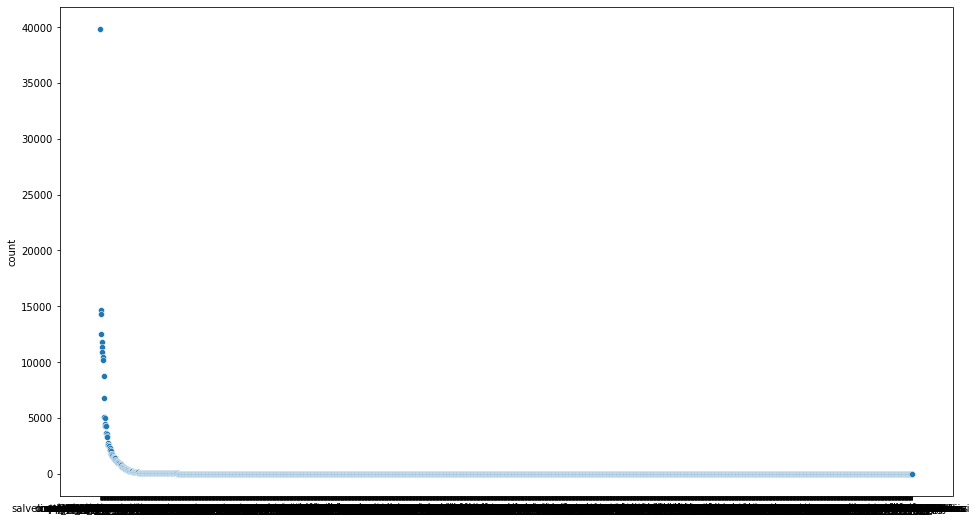

In [40]:
graph.figure(figsize=(16, 9))
sns.scatterplot(sums.index, sums['count'])
graph.show()

In [18]:
lake_locations.loc[lake_locations['lake_code'] == 'CA_ALB_S_000051']

,Hylak_id,lake_name_x,country_code,Lake_name,Country,Continent,Poly_src,Lake_type,Grand_id,surface_area_km2,...,Res_time,elevation_m,Slope_100,Wshd_area,longitude,latitude,lake_name_y,max_depth_m,lake_name,lake_code
6127,NaN,Narrow Lake,CA,NaN,NaN,NaN,NaN,NaN,NaN,1.14,...,NaN,NaN,NaN,NaN,-113.616667,54.583333,Narrow Lake,38.0,NaN,CA_ALB_S_000051


In [31]:
sum_test_df = pd.read_csv('/mnt/c/Users/imrit/Desktop/pandas_sum_test.csv')
col_dict = {'fish_2.1': 'fish_2', 'fish_3.1': 'fish_3', 'fish_3.2': 'fish_3'}
sum_test_df.rename(columns = col_dict, inplace=True)
sum_test_df

,location,year,fish_1,fish_2,fish_2,fish_3,fish_3,fish_3,fish_4
0,A1,2,1.0,1.0,NaN,1.0,NaN,1.0,1.0
1,A1,4,1.0,1.0,NaN,1.0,NaN,1.0,NaN
2,A1,6,1.0,1.0,1.0,1.0,NaN,NaN,1.0
3,A1,8,NaN,NaN,1.0,NaN,1.0,NaN,NaN
4,A1,10,NaN,NaN,1.0,NaN,1.0,NaN,1.0
5,A2,2,NaN,NaN,NaN,NaN,1.0,NaN,NaN
6,A2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,A2,6,1.0,1.0,NaN,1.0,NaN,1.0,1.0
8,A2,8,1.0,1.0,NaN,1.0,NaN,1.0,NaN
9,A2,10,1.0,1.0,1.0,1.0,NaN,1.0,1.0


In [34]:
summed_test_df = sum_test_df.sum(axis=1, level=0, min_count=1)
summed_test_df

,location,year,fish_1,fish_2,fish_3,fish_4
0,A1,2,1.0,1.0,2.0,1.0
1,A1,4,1.0,1.0,2.0,0.0
2,A1,6,1.0,2.0,1.0,1.0
3,A1,8,0.0,1.0,1.0,0.0
4,A1,10,0.0,1.0,1.0,1.0
5,A2,2,0.0,0.0,1.0,0.0
6,A2,4,0.0,0.0,0.0,0.0
7,A2,6,1.0,1.0,2.0,1.0
8,A2,8,1.0,1.0,2.0,0.0
9,A2,10,1.0,2.0,2.0,1.0


In [35]:
for col in ['fish_1', 'fish_2', 'fish_3', 'fish_4']:
    summed_test_df[col] = np.where(summed_test_df[col] > 0, 1, np.nan)

summed_test_df

,location,year,fish_1,fish_2,fish_3,fish_4
0,A1,2,1.0,1.0,1.0,1.0
1,A1,4,1.0,1.0,1.0,NaN
2,A1,6,1.0,1.0,1.0,1.0
3,A1,8,NaN,1.0,1.0,NaN
4,A1,10,NaN,1.0,1.0,1.0
5,A2,2,NaN,NaN,1.0,NaN
6,A2,4,NaN,NaN,NaN,NaN
7,A2,6,1.0,1.0,1.0,1.0
8,A2,8,1.0,1.0,1.0,NaN
9,A2,10,1.0,1.0,1.0,1.0


In [7]:
locations = pd.read_csv('/mnt/c/Users/imrit/Desktop/GENFISH_canada_us_lakes_jan_14_2022.csv')
locations

/home/arshad/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (2,6,10,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,latitude,longitude,hydro_match,hydro_dist,Hylak_id,ocean,match2river,river_hydro_dist,river_hydro_id,hydro_waterbody,...,Dis_avg,Res_time,Elevation,Slope_100,Wshd_area,Pour_long,Pour_lat,country_code,hyd_code,made_up_code_merged
0,45.095566,-74.434094,"[0.0, 754]",0.000000,754.0,NO,NaN,NaN,NaN,lake,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CA,HYD_754.0,CA_HYD_754.0
1,44.488300,-86.332200,"[0.0, 6]",0.000000,6.0,NO,NaN,NaN,NaN,lake,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CA,HYD_6.0,CANUS_HYD_6.0
2,45.669600,-83.887600,"[0.0, 8]",0.000000,8.0,NO,NaN,NaN,NaN,lake,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CA,HYD_8.0,CANUS_HYD_8.0
3,45.200000,-85.656700,"[0.0, 6]",0.000000,6.0,NO,NaN,NaN,NaN,lake,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CA,HYD_6.0,CANUS_HYD_6.0
4,45.510000,-81.146200,"[0.0, 8]",0.000000,8.0,NO,NaN,NaN,NaN,lake,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CA,HYD_8.0,CANUS_HYD_8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265839,43.771000,-79.142400,NaN,211.608253,7.0,NO,NaN,NaN,NaN,lake,...,7745.819,2450.5,73.0,-1.0,766137.4,-75.794246,44.480557,US,HYD_7.0,CANUS_HYD_7.0
265840,43.826000,-79.088600,NaN,456.711406,7.0,NO,NaN,NaN,NaN,lake,...,7745.819,2450.5,73.0,-1.0,766137.4,-75.794246,44.480557,US,HYD_7.0,CANUS_HYD_7.0
265841,43.822300,-79.072600,NaN,432.277693,7.0,NO,NaN,NaN,NaN,lake,...,7745.819,2450.5,73.0,-1.0,766137.4,-75.794246,44.480557,US,HYD_7.0,CANUS_HYD_7.0
265842,43.622100,-79.482700,NaN,120.735138,7.0,NO,NaN,NaN,NaN,lake,...,7745.819,2450.5,73.0,-1.0,766137.4,-75.794246,44.480557,US,HYD_7.0,CANUS_HYD_7.0


In [8]:
locations.columns

Index(['latitude', 'longitude', 'hydro_match', 'hydro_dist', 'Hylak_id',
       'ocean', 'match2river', 'river_hydro_dist', 'river_hydro_id',
       'hydro_waterbody', 'lake_name', 'made_up_code', 'hydro_id', 'Lake_name',
       'Country', 'Continent', 'Poly_src', 'Lake_type', 'Grand_id',
       'Lake_area', 'Shore_len', 'Shore_dev', 'Vol_total', 'Vol_res',
       'Vol_src', 'Depth_avg', 'Dis_avg', 'Res_time', 'Elevation', 'Slope_100',
       'Wshd_area', 'Pour_long', 'Pour_lat', 'country_code', 'hyd_code',
       'made_up_code_merged'],
      dtype='object')

In [9]:
locations['Country'].unique()

array([nan, 'United States of America'], dtype=object)

In [26]:
final_codes = hydro_sapna_ahi[['made_up_code_merged', 'lake_code']]
final_codes

,made_up_code_merged,lake_code
0,CA_HYD_754.0,CA_HYD_754.0
1,CANUS_HYD_6.0,US_HYD_6.0
2,CANUS_HYD_8.0,US_HYD_8.0
3,CANUS_HYD_5.0,US_HYD_5.0
4,CANUS_HYD_104335.0,US_HYD_104335.0
...,...,...
39100,US_HYD_1069642.0,US_HYD_1069642.0
39101,US_HYD_1054171.0,US_HYD_1054171.0
39102,US_HYD_114681.0,US_HYD_114681.0
39103,US_HYD_1066785.0,US_HYD_1066785.0


In [27]:
locations_final_codes = locations.merge(final_codes, how='left')
locations_final_codes

,latitude,longitude,hydro_match,hydro_dist,Hylak_id,ocean,match2river,river_hydro_dist,river_hydro_id,hydro_waterbody,...,Res_time,Elevation,Slope_100,Wshd_area,Pour_long,Pour_lat,country_code,hyd_code,made_up_code_merged,lake_code
0,45.095566,-74.434094,"[0.0, 754]",0.000000,754.0,NO,NaN,NaN,NaN,lake,...,NaN,NaN,NaN,NaN,NaN,NaN,CA,HYD_754.0,CA_HYD_754.0,CA_HYD_754.0
1,44.488300,-86.332200,"[0.0, 6]",0.000000,6.0,NO,NaN,NaN,NaN,lake,...,NaN,NaN,NaN,NaN,NaN,NaN,CA,HYD_6.0,CANUS_HYD_6.0,US_HYD_6.0
2,45.669600,-83.887600,"[0.0, 8]",0.000000,8.0,NO,NaN,NaN,NaN,lake,...,NaN,NaN,NaN,NaN,NaN,NaN,CA,HYD_8.0,CANUS_HYD_8.0,US_HYD_8.0
3,45.200000,-85.656700,"[0.0, 6]",0.000000,6.0,NO,NaN,NaN,NaN,lake,...,NaN,NaN,NaN,NaN,NaN,NaN,CA,HYD_6.0,CANUS_HYD_6.0,US_HYD_6.0
4,45.510000,-81.146200,"[0.0, 8]",0.000000,8.0,NO,NaN,NaN,NaN,lake,...,NaN,NaN,NaN,NaN,NaN,NaN,CA,HYD_8.0,CANUS_HYD_8.0,US_HYD_8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265843,43.771000,-79.142400,NaN,211.608253,7.0,NO,NaN,NaN,NaN,lake,...,2450.5,73.0,-1.0,766137.4,-75.794246,44.480557,US,HYD_7.0,CANUS_HYD_7.0,US_HYD_7.0
265844,43.826000,-79.088600,NaN,456.711406,7.0,NO,NaN,NaN,NaN,lake,...,2450.5,73.0,-1.0,766137.4,-75.794246,44.480557,US,HYD_7.0,CANUS_HYD_7.0,US_HYD_7.0
265845,43.822300,-79.072600,NaN,432.277693,7.0,NO,NaN,NaN,NaN,lake,...,2450.5,73.0,-1.0,766137.4,-75.794246,44.480557,US,HYD_7.0,CANUS_HYD_7.0,US_HYD_7.0
265846,43.622100,-79.482700,NaN,120.735138,7.0,NO,NaN,NaN,NaN,lake,...,2450.5,73.0,-1.0,766137.4,-75.794246,44.480557,US,HYD_7.0,CANUS_HYD_7.0,US_HYD_7.0


In [33]:
locations_final_codes.loc[locations_final_codes['made_up_code_merged'] == 'CA_ON_AHI_BSM_8321']

,latitude,longitude,hydro_match,hydro_dist,Hylak_id,ocean,match2river,river_hydro_dist,river_hydro_id,hydro_waterbody,...,Res_time,Elevation,Slope_100,Wshd_area,Pour_long,Pour_lat,country_code,hyd_code,made_up_code_merged,lake_code
27472,49.789444,-93.210278,"[nan, nan]",NaN,NaN,NaN,NaN,NaN,NaN,lake,...,NaN,NaN,NaN,NaN,NaN,NaN,CA,ON_AHI,CA_ON_AHI_BSM_8321,CA_ON_AHI_BSM_8321
